August: Animations of the vertical velocity (W) profiles at different depths using pcolormesh and contour lines.

In [1]:
import netCDF4 as nc
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cmocean as cmo
import os,sys,fnmatch,time
import numpy as np
import matplotlib.gridspec as gridspec

from salishsea_tools.nc_tools import scDataset

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

from matplotlib import animation

In [12]:
def get_files(dirname, fname, grid):
    files = []    
    for item in os.listdir(dirname):
        if fnmatch.fnmatchcase(item, fname + grid + "*.nc"):
            files += [os.path.join(dirname, item)]
    files.sort(key=os.path.basename)
    return files

# ------------------------------------------------------------------------------------------------
def get_vars(dirname, depth_ind):
    fname = "1_MCKNZ_1h_20170101_20170120_*"
    y,x = slice(1,-1,None), slice(1,-1,None)
    
    filesT = get_files(dirname, fname, 'grid_T')
    filesU = get_files(dirname, fname, 'grid_U') 
    filesW = get_files(dirname, fname, 'grid_W')
            
    with scDataset(filesT) as dsT, scDataset(filesU) as dsU, scDataset(filesW) as dsW:
        deptht = dsT.variables['deptht'][depth_ind]
        sozotaux = dsU.variables['sozotaux'][:,0,0]        
        vovecrtz0 = dsW.variables['vovecrtz'][:,depth_ind,y,x]
        
    with nc.Dataset(os.path.join(dirname, '1_mesh_mask.nc'), 'r') as dsM:
        tmask0 = dsM.variables['tmask'][0,depth_ind,y,x]
        
    tmask = np.tile(tmask0, (len(sozotaux),1, 1))  
    vovecrtz = np.ma.array(vovecrtz0, mask=1 - tmask)
    vovecrtz_cm = vovecrtz[:] * 100
    
    return vovecrtz_cm, sozotaux, deptht

In [13]:
dirname='/ocean/imachuca/Canyons/results_mackenzie/idealized/sbcana_forcings/agrif_wind_timestep/'

vovecrtzA, sozotaux, depthtA = get_vars(dirname, 7)
vovecrtzB, sozotaux, depthtB = get_vars(dirname, 9)
vovecrtzC, sozotaux, depthtC = get_vars(dirname, 11)

vovecrtz_all = [vovecrtzA, vovecrtzB, vovecrtzC]
deptht_all = [depthtA, depthtB, depthtC]

print(deptht_all)

[65.625, 83.125, 100.625]


In [14]:
def pcolormesh_velocity(ax, vel_array, time_ind, vm, ttl):
    xs = np.arange(vel_array.shape[-1])
    ys = np.arange(vel_array.shape[-2])
    vel = vel_array[time_ind,...]

    cmap = plt.get_cmap(cm.RdBu_r)
    cmap.set_bad('wheat')
    C = ax.pcolormesh(xs, ys, vel, vmin = -1*vm, vmax = vm, cmap = cmap)
    ax.set_xlim([0, xs[-1]]); ax.set_ylim([0, ys[-1]])
    ax.set_xlabel('X Indices (Child)', fontsize=13)
    ax.set_ylabel('Y Indices (Child)', fontsize=13, labelpad=10)
    ax.xaxis.set_ticks_position('none') 
    ax.yaxis.set_ticks_position('none') 
    ax.set_title(ttl, fontsize=20)
    
    levels = np.linspace(-1*vm, vm, 5).tolist()
    print(levels)
    c = ax.contour(vel, levels = levels, colors='k')
    ax.clabel(c, inline=1, fontsize=10)
    
    if time_ind == 0:
        cbar = plt.colorbar(C, ax=ax, pad=0.1, orientation='horizontal')
        cbar.ax.set_xticklabels(cbar.ax.get_xticklabels(), rotation=45)
    else:
        pass
    return ax

def plot_frames(ax1, ax2, ax3, axa, time_ind, vovecrtz_all, stress, deptht_all):
    depthtA, depthtB, depthtC = deptht_all[0], deptht_all[1], deptht_all[2]
    vovecrtzA, vovecrtzB, vovecrtzC = vovecrtz_all[0], vovecrtz_all[1], vovecrtz_all[2]
    
    vel_max = max(vovecrtzA.max(), vovecrtzB.max(), vovecrtzC.max(), key=abs)
    vel_min = max(vovecrtzA.min(), vovecrtzB.min(), vovecrtzC.min(), key=abs)
    vm0 = max([abs(vel_max), abs(vel_min)])
    vm = 0.4 * vm0 #stronger colours
    
    ttlA = '    (dep='+ str(int(depthtA)) + ' m)'
    ttlB = '    (dep='+ str(int(depthtB)) + ' m)'
    ttlC = '    (dep='+ str(int(depthtC)) + ' m)'
    ax1 = pcolormesh_velocity(ax1, vovecrtzA, time_ind, vm, 'W Velocity [cm s$^{-1}$]'+ttlA)
    ax2 = pcolormesh_velocity(ax2, vovecrtzB, time_ind, vm, 'W Velocity [cm s$^{-1}$]'+ttlB)
    ax3 = pcolormesh_velocity(ax3, vovecrtzC, time_ind, vm, 'W Velocity [cm s$^{-1}$]'+ttlC)
    
    axa.plot(stress[:time_ind], c='#384e72', linewidth=2.5)
    axa.set_xlim([0, stress.shape[0]])
    axa.set_ylim(stress.min(), stress.max())
    axa.set_xlabel('Time [hrs]', fontsize=13)
    axa.set_title('Wind Stress [Nm$^{-2}$]', fontsize=13)
    axa.grid(color='gray', linestyle='-')
    axa.xaxis.set_ticks_position('none') 
    axa.yaxis.set_ticks_position('none') 
    for pos in ['top', 'bottom', 'right', 'left']:
        ax1.spines[pos].set_edgecolor('gray')
        ax2.spines[pos].set_edgecolor('gray')
        ax3.spines[pos].set_edgecolor('gray')
        axa.spines[pos].set_edgecolor('gray')
        axa.spines[pos].set_visible(False)   
    plt.tight_layout(h_pad=0.5, rect=[0, 0, 1, 0.96])  
    return

[-0.06218322515487671, -0.031091612577438355, 0.0, 0.03109161257743836, 0.06218322515487671]
[-0.06218322515487671, -0.031091612577438355, 0.0, 0.03109161257743836, 0.06218322515487671]
[-0.06218322515487671, -0.031091612577438355, 0.0, 0.03109161257743836, 0.06218322515487671]


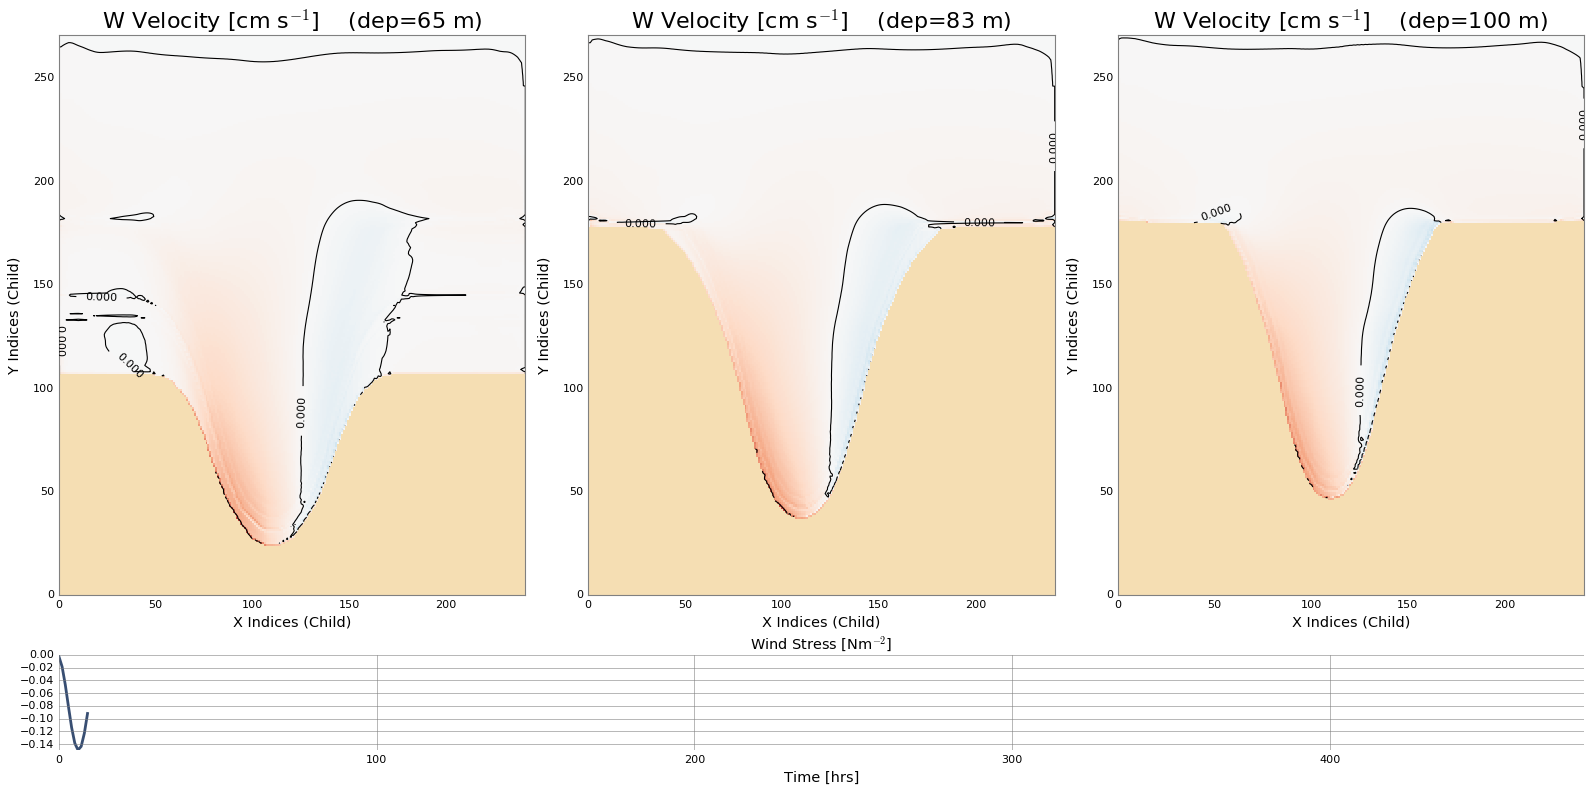

In [17]:
fig = plt.figure(figsize=(20, 12))
ax1 = plt.subplot2grid((6, 12), (0, 0), colspan=4, rowspan=4)
ax2 = plt.subplot2grid((6, 12), (0, 4), colspan=4, rowspan=4, sharey=ax1)
ax3 = plt.subplot2grid((6, 12), (0, 8), colspan=4, rowspan=4, sharey=ax1)
axa = plt.subplot2grid((6, 12), (4, 0), colspan=12)

time_ind = 10
plot_frames(ax1, ax2, ax3, axa, time_ind, vovecrtz_all, sozotaux, deptht_all)